In [1]:
!pip uninstall sagemaker -y && pip install sagemaker

Found existing installation: sagemaker 1.71.0
Uninstalling sagemaker-1.71.0:
  Successfully uninstalled sagemaker-1.71.0
     |████████████████████████████████| 296 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 3.8 MB/s eta 0:00:011
  Created wheel for sagemaker: filename=sagemaker-2.3.0-py2.py3-none-any.whl size=414364 sha256=8b586d62290c31fccfb4ef03aba5e461ebd5eba04910311156ea857fdbbbde13
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ab/83/60/e6932c9fd595e8b62bb5c394f411fd13329158762f9bb9988f
Successfully built sagemaker
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


NameError: name 'sagemaker' is not defined

In [2]:
%%time 
import pickle, gzip, urllib.request, json
import numpy as np

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(train_set[0].shape)

(50000, 784)
CPU times: user 975 ms, sys: 302 ms, total: 1.28 s
Wall time: 13.2 s


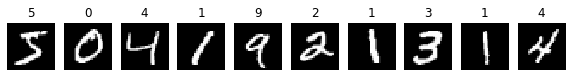

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))

for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    ax = axes[i]
    imgplot = ax.imshow(img_reshape, cmap='gray')
    ax.axis("off")
    ax.set_title(label)

plt.show()

In [4]:
%%time

import os
import boto3
import re
import copy
import time
import io
import struct
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='sagemaker-200816' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data

s3_client = boto3.client("s3")
    
def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        
        print(f"{data_partition_name}: {data_partition[0].shape} {data_partition[1].shape}")
        
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]

        if data_partition_name != 'test':
            # examples: [[y_label, labels...], ...]
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
            
        np.savetxt('data.csv', examples, delimiter=',')
            
        key = f"{prefix}/{data_partition_name}/examples"
        url = f"s3://{prefix}/{data_partition_name}"
        
        s3_client.upload_file(Filename="data.csv", Bucket=bucket, Key=key)

        print(f"Done writing to {url}")

convert_data()

train: (50000, 784) (50000,)
Done writing to s3://sagemaker/xgboost-mnist/train
validation: (10000, 784) (10000,)
Done writing to s3://sagemaker/xgboost-mnist/validation
test: (10000, 784) (10000,)
Done writing to s3://sagemaker/xgboost-mnist/test
CPU times: user 50.1 s, sys: 7.58 s, total: 57.6 s
Wall time: 1min 13s


In [5]:
import sagemaker
from sagemaker import image_uris

container = image_uris.retrieve('xgboost', region=region, version="latest")

In [6]:
train_data_url = f"s3://{bucket}/{prefix}/train"
validation_data_url = f"s3://{bucket}/{prefix}/validation"
s3_output_location = f"s3://{bucket}/{prefix}/xgboost_model_sdk"

print(train_data_url)

s3://sagemaker-200816/sagemaker/xgboost-mnist/train


In [7]:
xgb_model = sagemaker.estimator.Estimator(container,
                                      role, 
                                      instance_count=1, 
                                      instance_type='ml.m4.xlarge',
                                      volume_size = 5,
                                      output_path=s3_output_location,
                                      sagemaker_session=sagemaker.Session())  

In [8]:
xgb_model.set_hyperparameters(max_depth = 5,
                          eta = .2,
                          gamma = 4,
                          min_child_weight = 6,
                          silent = 0,
                          objective = "multi:softmax",
                          num_class = 10,
                          num_round = 10)

In [9]:
train_channel = sagemaker.inputs.TrainingInput(train_data_url, content_type='text/csv')
valid_channel = sagemaker.inputs.TrainingInput(validation_data_url, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

In [10]:
xgb_model.fit(inputs=data_channels, logs=True)

2020-08-16 05:58:30 Starting - Starting the training job...
2020-08-16 05:58:34 Starting - Launching requested ML instances......
2020-08-16 05:59:44 Starting - Preparing the instances for training...
2020-08-16 06:00:29 Downloading - Downloading input data......
2020-08-16 06:01:12 Training - Downloading the training image.Arguments: train
[2020-08-16:06:01:36:INFO] Running standalone xgboost training.
[2020-08-16:06:01:36:INFO] File size need to be processed in the node: 1122.95mb. Available memory size in the node: 8472.73mb
[2020-08-16:06:01:36:INFO] Determined delimiter of CSV input is ','
[06:01:36] S3DistributionType set as FullyReplicated
[06:01:43] 50000x784 matrix with 39200000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-08-16:06:01:43:INFO] Determined delimiter of CSV input is ','
[06:01:43] S3DistributionType set as FullyReplicated
[06:01:44] 10000x784 matrix with 7840000 entries loaded from /opt/ml/input/data/validation?format=c

In [57]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                 serializer=sagemaker.serializers.CSVSerializer(),
                                instance_type='ml.t2.medium')

---------------!

In [58]:
test_key = f"{prefix}/test/examples"
s3_client.download_file(Bucket=bucket, Key=test_key, Filename="test_data")

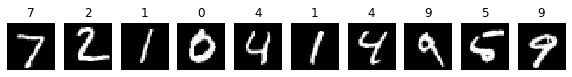

In [59]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))

for i in range(0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    ax = axes[i]
    imgplot = ax.imshow(img_reshape, cmap='gray')
    ax.axis("off")
    ax.set_title(label)

plt.show()

In [74]:
with open('test_data', 'r') as f:
    for j in range(0,10):
        single_test = f.readline()
        result = xgb_predictor.predict(single_test)
        print(int(float(result.decode())), end=" ")

7 2 1 0 4 1 4 9 5 9 

In [75]:
# The location of the test dataset
batch_input = f"s3://{bucket}/{prefix}/test/examples"
# The location to store the results of the batch transform job
batch_output = f"s3://{bucket}/{prefix}/batch-inference"

transformer = xgb_model.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

transformer.wait()

..............................
2020-08-16T07:10:38.614:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-08-16 07:10:38 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-16 07:10:38 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-08-16 07:10:38 +0000] [1] [INFO] Using worker: gevent
[2020-08-16 07:10:38 +0000] [37] [INFO] Booting worker with pid: 37
[2020-08-16:07:10:38:INFO] Model loaded successfully for worker : 37
Arguments: serve
[2020-08-16 07:10:38 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-08-16 07:10:38 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-08-16 07:10:38 +0000] [1] [INFO] Using worker: gevent
[2020-08-16 07:10:38 +0000] [37] [INFO] Booting worker with pid: 37
[2020-08-16:07:10:38:INFO] Model loaded successfully for worker : 37
[2020-08-16 07:10:38 +0000] [38] [INFO] Booting worker with pid: 38
[2020-08-16 07:10:38 +0000] [39] [INFO] Booting worker with pid: 39
[2020-08-

In [78]:
test_key = f"{prefix}/batch-inference/examples.out"
s3_client.download_file(Bucket=bucket, Key=test_key, Filename="batch_results")

In [80]:
with open('batch_results') as f:
    results = f.readlines()
for j in range (0, 50):
    print(int(float(results[j])), end=" ")

7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 

In [90]:
import boto3
import os
import io
import boto3
import json
import csv

ENDPOINT_NAME = "xgboost-2020-08-16-06-47-01-579"
runtime = boto3.client('runtime.sagemaker')

with open('test_data', 'r') as f:
    for j in range(0,50):
        payload = f.readline()
        response = runtime.invoke_endpoint(EndpointName=ENDPOINT_NAME,
                                           ContentType='text/csv',
                                           Body=payload)
        
        result = json.loads(response["Body"].read().decode())
        

        print(int(float(result)), end=" ")

7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 

In [ ]:
batch_results
test_data
mnist.pkl.gz